In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
from torch.nn import functional as F
import torchvision
from torchvision import datasets,transforms
import torchvision.transforms as transforms

## 1: Import dataset

In [2]:
train_dataset = torchvision.datasets.MNIST('classifier_data', train=True, download=True)
test_dataset  = torchvision.datasets.MNIST('classifier_data', train=False, download=True)

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

train_dataset.transform=transform
test_dataset.transform=transform

m=len(train_dataset)


Extracting classifier_data/MNIST/raw/train-images-idx3-ubyte.gz to classifier_data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting classifier_data/MNIST/raw/train-labels-idx1-ubyte.gz to classifier_data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting classifier_data/MNIST/raw/t10k-images-idx3-ubyte.gz to classifier_data/MNIST/raw




Extracting classifier_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to classifier_data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## 2. Define cnn class

In [3]:
class ConvNet(nn.Module):
    def __init__(self,h1=96):
        # We optimize dropout rate in a convolutional neural network.
        super(ConvNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.drop1=nn.Dropout2d(p=0.5)   

        self.fc1 = nn.Linear(32 * 7 * 7, h1)
        self.drop2=nn.Dropout2d(p=0.1)

        self.fc2 = nn.Linear(h1, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x),kernel_size = 2))

        x = F.relu(F.max_pool2d(self.conv2(x),kernel_size = 2))
        x = self.drop1(x)

        x = x.view(x.size(0),-1)

        x = F.relu(self.fc1(x))
        x = self.drop2(x)

        x = self.fc2(x)

        return x

## 3.Initialize 

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
criterion = nn.CrossEntropyLoss()

In [14]:
dataset = ConcatDataset([train_dataset, test_dataset])

num_epochs=10
batch_size=128
k=10
splits=KFold(n_splits=k,shuffle=True,random_state=42)
foldperf={}

## 4.K Fold Cross Validation

In [8]:
def train_epoch(model,device,dataloader,loss_fn,optimizer):
    train_loss,train_correct=0.0,0
    model.train()
    for images, labels in dataloader:

        images,labels = images.to(device),labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = loss_fn(output,labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(output.data, 1)
        train_correct += (predictions == labels).sum().item()

    return train_loss,train_correct

In [9]:
def valid_epoch(model,device,dataloader,loss_fn):
    valid_loss, val_correct = 0.0, 0
    model.eval()
    for images, labels in dataloader:

        images,labels = images.to(device),labels.to(device)
        output = model(images)
        loss=loss_fn(output,labels)
        valid_loss+=loss.item()*images.size(0)
        scores, predictions = torch.max(output.data,1)
        val_correct+=(predictions == labels).sum().item()

    return valid_loss,val_correct

In [15]:
for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(dataset)))):

    print('Fold {}'.format(fold + 1))

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    model = ConvNet()
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.002)

    history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}

    for epoch in range(num_epochs):
        train_loss, train_correct=train_epoch(model,device,train_loader,criterion,optimizer)
        test_loss, test_correct=valid_epoch(model,device,test_loader,criterion)

        train_loss = train_loss / len(train_loader.sampler)
        train_acc = train_correct / len(train_loader.sampler) * 100
        test_loss = test_loss / len(test_loader.sampler)
        test_acc = test_correct / len(test_loader.sampler) * 100

        print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Test Loss:{:.3f} AVG Training Acc {:.2f} % AVG Test Acc {:.2f} %".format(epoch + 1,
                                                                                                             num_epochs,
                                                                                                             train_loss,
                                                                                                             test_loss,
                                                                                                             train_acc,
                                                                                                             test_acc))
        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)

    foldperf['fold{}'.format(fold+1)] = history  

torch.save(model,'k_cross_CNN.pt')    

Fold 1
Epoch:1/10 AVG Training Loss:0.229 AVG Test Loss:0.071 AVG Training Acc 92.96 % AVG Test Acc 97.73 %
Epoch:2/10 AVG Training Loss:0.075 AVG Test Loss:0.051 AVG Training Acc 97.65 % AVG Test Acc 98.11 %
Epoch:3/10 AVG Training Loss:0.059 AVG Test Loss:0.046 AVG Training Acc 98.23 % AVG Test Acc 98.57 %
Epoch:4/10 AVG Training Loss:0.050 AVG Test Loss:0.036 AVG Training Acc 98.47 % AVG Test Acc 98.76 %
Epoch:5/10 AVG Training Loss:0.041 AVG Test Loss:0.033 AVG Training Acc 98.73 % AVG Test Acc 98.94 %
Epoch:6/10 AVG Training Loss:0.041 AVG Test Loss:0.030 AVG Training Acc 98.72 % AVG Test Acc 98.94 %
Epoch:7/10 AVG Training Loss:0.035 AVG Test Loss:0.032 AVG Training Acc 98.89 % AVG Test Acc 98.83 %
Epoch:8/10 AVG Training Loss:0.034 AVG Test Loss:0.044 AVG Training Acc 98.95 % AVG Test Acc 98.66 %
Epoch:9/10 AVG Training Loss:0.030 AVG Test Loss:0.036 AVG Training Acc 99.04 % AVG Test Acc 98.87 %
Epoch:10/10 AVG Training Loss:0.029 AVG Test Loss:0.029 AVG Training Acc 99.05 % AVG

In [16]:
testl_f,tl_f,testa_f,ta_f=[],[],[],[]
k=10
for f in range(1,k+1):

     tl_f.append(np.mean(foldperf['fold{}'.format(f)]['train_loss']))
     testl_f.append(np.mean(foldperf['fold{}'.format(f)]['test_loss']))

     ta_f.append(np.mean(foldperf['fold{}'.format(f)]['train_acc']))
     testa_f.append(np.mean(foldperf['fold{}'.format(f)]['test_acc']))

print('Performance of {} fold cross validation'.format(k))
print("Average Training Loss: {:.3f} \t Average Test Loss: {:.3f} \t Average Training Acc: {:.2f} \t Average Test Acc: {:.2f}".format(np.mean(tl_f),np.mean(testl_f),np.mean(ta_f),np.mean(testa_f)))     

Performance of 10 fold cross validation
Average Training Loss: 0.065 	 Average Test Loss: 0.038 	 Average Training Acc: 97.98 	 Average Test Acc: 98.84


In [17]:
diz_ep = {'train_loss_ep':[],'test_loss_ep':[],'train_acc_ep':[],'test_acc_ep':[]}

for i in range(num_epochs):
      diz_ep['train_loss_ep'].append(np.mean([foldperf['fold{}'.format(f+1)]['train_loss'][i] for f in range(k)]))
      diz_ep['test_loss_ep'].append(np.mean([foldperf['fold{}'.format(f+1)]['test_loss'][i] for f in range(k)]))
      diz_ep['train_acc_ep'].append(np.mean([foldperf['fold{}'.format(f+1)]['train_acc'][i] for f in range(k)]))
      diz_ep['test_acc_ep'].append(np.mean([foldperf['fold{}'.format(f+1)]['test_acc'][i] for f in range(k)]))

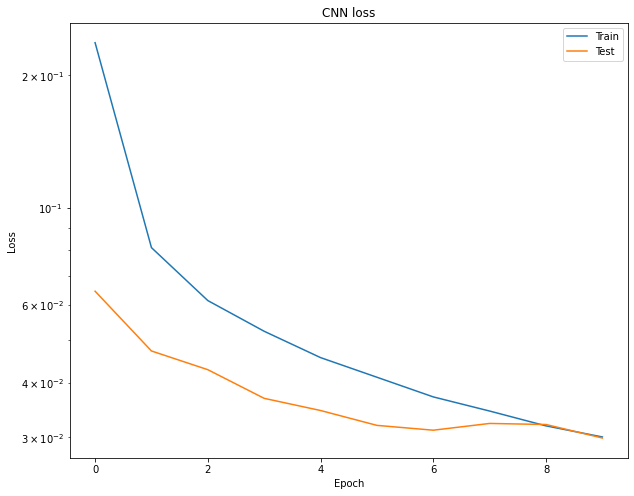

In [18]:
# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_ep['train_loss_ep'], label='Train')
plt.semilogy(diz_ep['test_loss_ep'], label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.grid()
plt.legend()
plt.title('CNN loss')
plt.show()

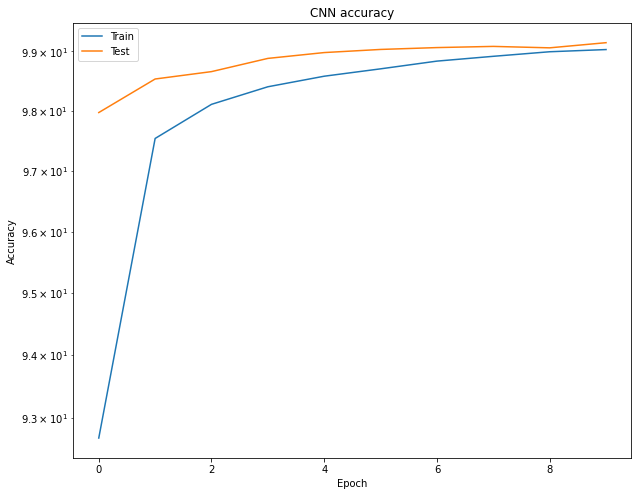

In [19]:
# Plot accuracies
plt.figure(figsize=(10,8))
plt.semilogy(diz_ep['train_acc_ep'], label='Train')
plt.semilogy(diz_ep['test_acc_ep'], label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.grid()
plt.legend()
plt.title('CNN accuracy')
plt.show()